## 1. Bộ dữ liệu

> * Bộ dữ liệu được sử dụng trong dự án này là ***một phần*** của một bộ dữ liệu gốc chứa các đánh giá sản phẩm và metadata từ Amazon, bao gồm **142.8 triệu** đánh giá từ tháng 5 năm 1996 đến tháng 7 năm 2014. [Amazon product data](https://cseweb.ucsd.edu/~jmcauley/datasets/amazon/links.html)
>   
> * Bộ dữ liệu này bao gồm các đánh giá (điểm đánh giá, văn bản, số phiếu bầu hữu ích), metadata sản phẩm (mô tả, thông tin danh mục, giá cả, thương hiệu, và đặc điểm hình ảnh), và liên kết (đồ thị sản phẩm được xem và được mua cùng).
>
> * Chúng ta làm việc với dữ liệu về các sản phẩm làm đẹp (Beauty Products), với dataset như sau:

**ratings_Beauty.csv**: chứa 2,023,070 đánh giá từ người dùng cho các sản phẩm.

### Mục tiêu: xây dựng Hệ gợi ý sản phẩm cho người dùng theo phương pháp: Collaborative Filtering

## 2. Tiền xử lý dữ liệu

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

plt.style.use("ggplot")


### 2.1. Đọc dữ liệu thô

In [17]:
file_path = '../dataset/ratings_Beauty.csv'
amazon_ratings = pd.read_csv(file_path)
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()


,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [18]:
amazon_ratings.shape

(2023070, 4)

### 2.2. Tạo Utility Matrix

Trong hệ thống gợi ý, một trong những phương pháp phổ biến để dự đoán rating cho một sản phẩm là sử dụng độ đo tương đồng giữa các user. Cách tiếp cận này dựa trên ý tưởng của thuật toán **K-Nearest Neighbors (KNN)**, một thuật toán học máy không giám sát cơ bản được sử dụng rộng rãi trong các bài toán phân loại và hồi quy. Dưới đây là các bước chi tiết thực hiện:


In [19]:
amazon_ratings1 = amazon_ratings.head(100000)

Đầu tiên, tạo một Utility Matrix từ dữ liệu đánh giá của người dùng, trong đó mỗi hàng tương ứng với một sản phẩm và mỗi cột tương ứng với một người dùng. Giá trị trong matrix là rating mà người dùng dành cho sản phẩm đó.

In [20]:
# Tạo utility matrix
utility_matrix = amazon_ratings1.pivot(index='ProductId', columns='UserId', values='Rating')

In [21]:
utility_matrix.head()

UserId,A00205921JHJK5X9LNP42,A00473363TJ8YSZ3YAGG9,A00700212KB3K0MVESPIY,A0081289HG0BXFQJQUWW,A01247753D6GFZD87MUV8,A01379141PEJ6FIH7UH38,A0143622X8ZC66HZXLUP,A01437583CZ7V02UKZQ5S,A01456542S5QPYUEGJXR8,A01907982I6OHXDYN5HD6,...,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZS7W015QH2L,AZZSAMMJPJKJ1,AZZSNN1LC94VF,AZZTJQ7CQZUD8,AZZVCBG5G4EV8,AZZWJ3LICUEKJ,AZZWPNME0GQZ2,AZZZLM1E5JJ8C
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0558925278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0733001998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0737104473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0762451459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
utility_matrix.shape

(6384, 91656)

Chuẩn hóa Utility Matrix: Tính toán trung bình các rating của mỗi user và trừ đi giá trị trung bình này từ các rating hiện tại. Việc này giúp giảm ảnh hưởng của sự khác biệt về thang điểm đánh giá giữa các user.

In [25]:
# Tính trung bình chỉ từ các giá trị đã có
mean_ratings = utility_matrix.mean(axis=0, skipna=True)

# Chuẩn hóa utility matrix bằng cách trừ đi trung bình
normalized_matrix = utility_matrix.sub(mean_ratings, axis=1)

# Fill các giá trị missing bằng 0 sau khi chuẩn hóa
normalized_matrix = normalized_matrix.fillna(0)

In [63]:
# Hiển thị normalized matrix
normalized_matrix.head(100000)

UserId,A00205921JHJK5X9LNP42,A00473363TJ8YSZ3YAGG9,A00700212KB3K0MVESPIY,A0081289HG0BXFQJQUWW,A01247753D6GFZD87MUV8,A01379141PEJ6FIH7UH38,A0143622X8ZC66HZXLUP,A01437583CZ7V02UKZQ5S,A01456542S5QPYUEGJXR8,A01907982I6OHXDYN5HD6,...,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZS7W015QH2L,AZZSAMMJPJKJ1,AZZSNN1LC94VF,AZZTJQ7CQZUD8,AZZVCBG5G4EV8,AZZWJ3LICUEKJ,AZZWPNME0GQZ2,AZZZLM1E5JJ8C
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0558925278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0733001998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0737104473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0762451459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B0002VNKRM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0002VNKSG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0002VNLG2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# Chuyển đổi sang định dạng sparse matrix để tiết kiệm bộ nhớ
sparse_matrix = csr_matrix(normalized_matrix)

Sử dụng ma trận đã chuẩn hóa để tính toán độ đo tương đồng giữa các user. Ở đây chúng ta dùng độ đo tương đồng $cosine$. Độ đo $cosine$ cho biết mức độ tương tự giữa hai user dựa trên góc giữa hai vector rating của chúng trong không gian nhiều chiều.


$$
\text{cosine\_similarity}(\mathbf{u}_1, \mathbf{u}_2) = \text{cos}(\mathbf{u}_1, \mathbf{u}_2) 
= \frac{\mathbf{u}_1^T \mathbf{u}_2}{||\mathbf{u}_1||_2 \cdot ||\mathbf{u}_2||_2} \tag{1}
$$

In [33]:
# Tính toán độ đo tương đồng cosine giữa các user sử dụng ma trận thưa
user_similarity = cosine_similarity(sparse_matrix.T, dense_output=False)

# Chuyển đổi thành ma trận thưa
user_similarity_sparse = csr_matrix(user_similarity)

# Đặt tất cả các giá trị trên đường chéo bằng 1
user_similarity_sparse.setdiag(1)

In [48]:
print(user_similarity)

  (1, 68002)	0.1889822365046136
  (1, 90045)	-0.15724272550828783
  (1, 82170)	-0.10959932487023817
  (1, 53656)	0.5
  (1, 37184)	-0.4999999999999999
  (1, 34018)	0.4999999999999999
  (1, 28612)	-0.4364357804719847
  (1, 13625)	-0.22450662753346862
  (1, 1)	0.9999999999999998
  (53, 72341)	0.28867513459481275
  (53, 64320)	0.35355339059327373
  (53, 91047)	0.43643578047198484
  (53, 89638)	0.35355339059327373
  (53, 86456)	-0.4999999999999999
  (53, 86241)	0.4999999999999999
  (53, 84901)	-0.5773502691896258
  (53, 84076)	-0.4999999999999999
  (53, 82886)	0.577350269189626
  (53, 82633)	0.2886751345948129
  (53, 82628)	0.16903085094570325
  (53, 80329)	-0.4999999999999999
  (53, 79414)	0.4999999999999999
  (53, 79394)	0.4999999999999999
  (53, 78523)	0.2886751345948126
  (53, 78121)	-0.2886751345948126
  :	:
  (91647, 51691)	-0.5
  (91647, 50418)	0.5
  (91647, 49912)	0.5
  (91647, 47311)	-0.5
  (91647, 46898)	0.5000000000000001
  (91647, 40597)	-0.2886751345948129
  (91647, 40216)	-0.5

In [54]:
user_similarity_sparse.shape

(91656, 91656)

Kết quả của việc tính toán độ đo tương đồng cosine là một ma trận tương đồng, trong đó mỗi phần tử $(m$,$n)$ biểu thị độ tương đồng giữa người dùng $m$ và người dùng $n$.

In [58]:
print(user_similarity_sparse[:10, :10].todense())

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


Các ô trên đường chéo đều bằng 1 vì đó là $cos$ của góc giữa 1 vector và chính nó, tức $cos(0)=1$.

Tiếp theo, xây dựng hàm dự đoán ratings.
- Hàm sẽ thực hiện phán đoán rating của người dùng $u$ cho sản phẩm $i$, dựa trên $k$ user tương đồng với nó nhất (theo độ đo cosine ở trên) mà người dùng u đã đánh giá (K-Nearest Neighbors).

- Rating phán đoán sẽ được tính bằng trung bình có trọng số của $k$ user đó.

In [153]:
# Tạo bản đồ user và item sang chỉ mục
user_idx_map = {user: idx for idx, user in enumerate(utility_matrix.columns)}
item_idx_map = {item: idx for idx, item in enumerate(utility_matrix.index)}

In [199]:
def predict_rating(user_id, item_id, utility_matrix, user_similarity, user_idx_map, item_idx_map, k=5):
    if item_id not in utility_matrix.index or user_id not in utility_matrix.columns:
        return None
    
    item_ratings = utility_matrix.loc[item_id].dropna()
    
    if item_ratings.empty:
        return None
    
    if user_id in item_ratings.index:
        return utility_matrix.at[item_id, user_id]
    
    item_rated_users = item_ratings.index
    user_idx = user_idx_map[user_id]
    
    item_rated_indices = [user_idx_map[user] for user in item_rated_users]
    similarities = user_similarity[user_idx, item_rated_indices].toarray().flatten()
    
    if len(similarities) == 0:
        return None
    
    top_k_indices = np.argsort(similarities)[-k:]
    top_k_similarities = similarities[top_k_indices]
    top_k_similar_users = [item_rated_users[i] for i in top_k_indices]
    
    if np.sum(top_k_similarities) == 0:
        return None
    
    top_k_ratings = item_ratings[top_k_similar_users]
    weighted_sum = np.dot(top_k_ratings, top_k_similarities)
    sum_of_weights = np.sum(top_k_similarities)
    
    if sum_of_weights == 0:
        return None
    
    return weighted_sum / sum_of_weights

In [201]:
# Ví dụ cụ thể: Dự đoán rating của user 'A3OMF1C8HBGJEN' cho sản phẩm 'B0002UBEI0'
user_id = 'A3DXBLP5Q1KRQA'
item_id = '1304482634'

predicted_rating = predict_rating(user_id, item_id, utility_matrix, user_similarity, user_idx_map, item_idx_map, k=5)
print(f"Dự đoán rating của user '{user_id}' cho sản phẩm '{item_id}': {predicted_rating}")

Dự đoán rating của user 'A3DXBLP5Q1KRQA' cho sản phẩm '1304482634': 2.0


## 3. Đánh giá mô hình

Chúng ta dùng một số phương pháp và chỉ số đo lường phổ biến trong hệ thống gợi ý như Root Mean Squared Error (RMSE) và Mean Absolute Error (MAE).

Chia tập dữ liệu thành tập huấn luyện và tập kiểm tra và dự đoán rating trên tập kiểm tra:

In [191]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Chia dữ liệu thành tập train và test
train_data = amazon_ratings1.sample(frac=0.8, random_state=1)
test_data = amazon_ratings1.drop(train_data.index)

# Tạo utility matrix từ tập train
utility_matrix_train = train_data.pivot(index='ProductId', columns='UserId', values='Rating')
mean_ratings_train = utility_matrix_train.mean(axis=0, skipna=True)
normalized_matrix_train = utility_matrix_train.sub(mean_ratings_train, axis=1)
normalized_matrix_train = normalized_matrix_train.fillna(0)
sparse_matrix_train = csr_matrix(normalized_matrix_train)
user_similarity_train = cosine_similarity(sparse_matrix_train.T, dense_output=False)
user_similarity_train_sparse = csr_matrix(user_similarity_train)
user_similarity_train_sparse.setdiag(1)

In [192]:
# Tạo bản đồ user và item sang chỉ mục cho tập train
user_idx_map_train = {user: idx for idx, user in enumerate(utility_matrix_train.columns)}
item_idx_map_train = {item: idx for idx, item in enumerate(utility_matrix_train.index)}

In [193]:
# Tính metrics MAE, RMSE và R-squared cho k=5
true_ratings = []
predicted_ratings = []

for idx, row in test_data.iterrows():
    user_id = row['UserId']
    item_id = row['ProductId']
    true_rating = row['Rating']
    
    predicted_rating = predict_rating(user_id, item_id, utility_matrix_train, user_similarity_train_sparse, user_idx_map_train, item_idx_map_train, k=5)
    
    if predicted_rating is not None:
        true_ratings.append(true_rating)
        predicted_ratings.append(predicted_rating)

In [197]:
mae = mean_absolute_error(true_ratings, predicted_ratings)
rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))

print(f"k=5 -> MAE: {mae}, RMSE: {rmse}")

k=5 -> MAE: 1.2538189571571048, RMSE: 1.7172163801442004


In [189]:
# Thử nghiệm với các giá trị khác nhau của k
k_values = [1, 3, 5, 7, 9, 10]
results = []

for k in k_values:
    true_ratings = []
    predicted_ratings = []
    
    for idx, row in test_data.iterrows():
        user_id = row['UserId']
        item_id = row['ProductId']
        true_rating = row['Rating']
        
        predicted_rating = predict_rating(user_id, item_id, utility_matrix_train, user_similarity_train_sparse, user_idx_map_train, item_idx_map_train, k=k)
        
        if predicted_rating is not None:
            true_ratings.append(true_rating)
            predicted_ratings.append(predicted_rating)
    
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    
    results.append((k, mae, rmse))
    print(f"k={k} -> MAE: {mae}, RMSE: {rmse}")


k=1 -> MAE: 1.318840579710145, RMSE: 1.8137957637131497
k=3 -> MAE: 1.2574576785375413, RMSE: 1.7200915295540729
k=5 -> MAE: 1.2538189571571048, RMSE: 1.7172163801442004
k=7 -> MAE: 1.2512090741542277, RMSE: 1.715680430698545
k=9 -> MAE: 1.2476203730948814, RMSE: 1.7075696784756238
k=10 -> MAE: 1.2476203730948814, RMSE: 1.7075696784756238


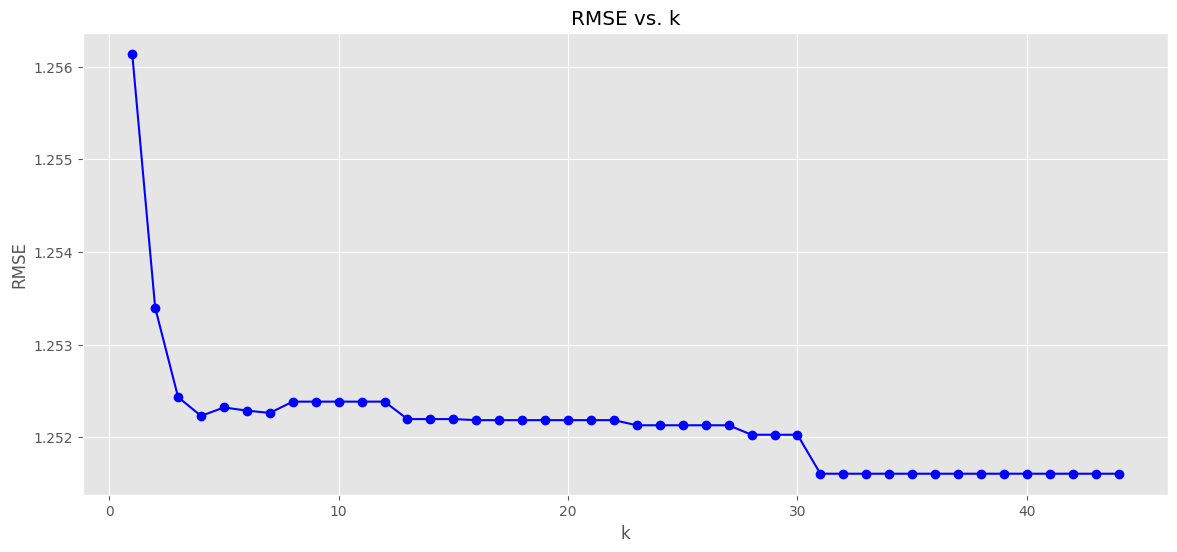

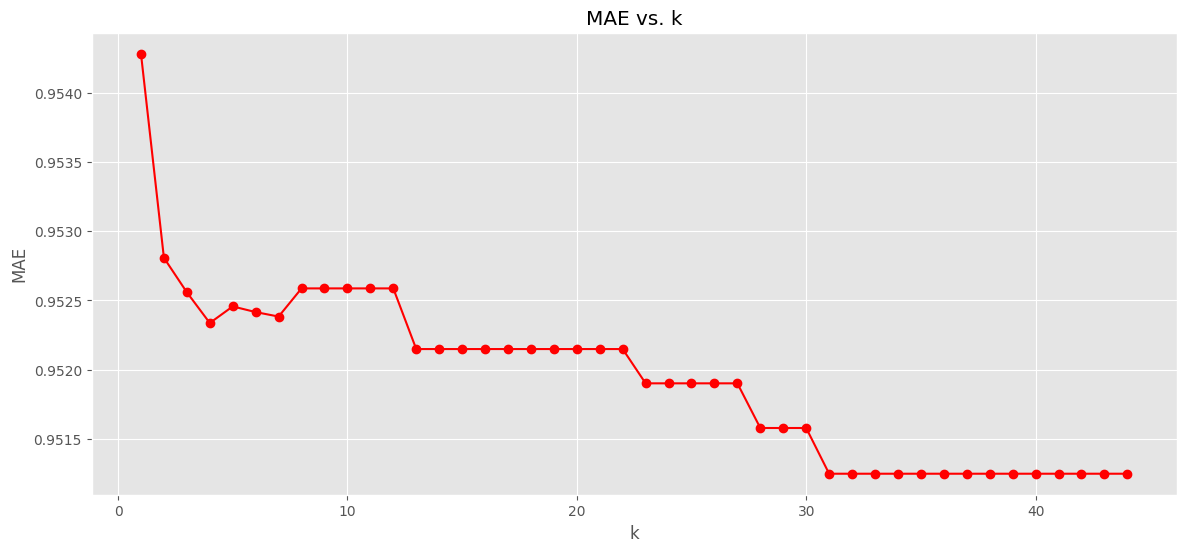

In [149]:
# Giá trị k từ 1 đến 45
k_values = range(1, 45)
mae_values = []
rmse_values = []

for k in k_values:
    true_ratings = []
    predicted_ratings = []
    
    for idx, row in test_data.iterrows():
        user_id = row['UserId']
        item_id = row['ProductId']
        true_rating = row['Rating']
        
        predicted_rating = predict_rating(user_id, item_id, utility_matrix_train, user_similarity_train_sparse, user_idx_map_train, item_idx_map_train, k=k)
        
        if predicted_rating is not None:
            true_ratings.append(true_rating)
            predicted_ratings.append(predicted_rating)
    
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    
    mae_values.append(mae)
    rmse_values.append(rmse)

# Vẽ biểu đồ cho RMSE
plt.figure(figsize=(14, 6))
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='b')
plt.title('RMSE vs. k')
plt.xlabel('k')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

# Vẽ biểu đồ cho MAE
plt.figure(figsize=(14, 6))
plt.plot(k_values, mae_values, marker='o', linestyle='-', color='r')
plt.title('MAE vs. k')
plt.xlabel('k')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

In [152]:
# Thử nghiệm với các giá trị khác nhau của k
k_values = range(30, 40)
results = []

for k in k_values:
    true_ratings = []
    predicted_ratings = []
    
    for idx, row in test_data.iterrows():
        user_id = row['UserId']
        item_id = row['ProductId']
        true_rating = row['Rating']
        
        predicted_rating = predict_rating(user_id, item_id, utility_matrix_train, user_similarity_train_sparse, user_idx_map_train, item_idx_map_train, k=k)
        
        if predicted_rating is not None:
            true_ratings.append(true_rating)
            predicted_ratings.append(predicted_rating)
    
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    
    results.append((k, mae, rmse))
    print(f"k={k} -> MAE: {mae}, RMSE: {rmse}")

# Chọn k tốt nhất
best_k = sorted(results, key=lambda x: x[2])[0][0]
print(f"Best k: {best_k}")


k=30 -> MAE: 0.9515782398065253, RMSE: 1.2520273845981789
k=31 -> MAE: 0.9512480303520437, RMSE: 1.25160686721809
k=32 -> MAE: 0.9512480303520437, RMSE: 1.25160686721809
k=33 -> MAE: 0.9512480303520437, RMSE: 1.25160686721809
k=34 -> MAE: 0.9512480303520437, RMSE: 1.25160686721809
k=35 -> MAE: 0.9512480303520437, RMSE: 1.25160686721809
k=36 -> MAE: 0.9512480303520437, RMSE: 1.25160686721809
k=37 -> MAE: 0.9512480303520437, RMSE: 1.25160686721809
k=38 -> MAE: 0.9512480303520437, RMSE: 1.25160686721809
k=39 -> MAE: 0.9512480303520437, RMSE: 1.25160686721809
Best k: 31


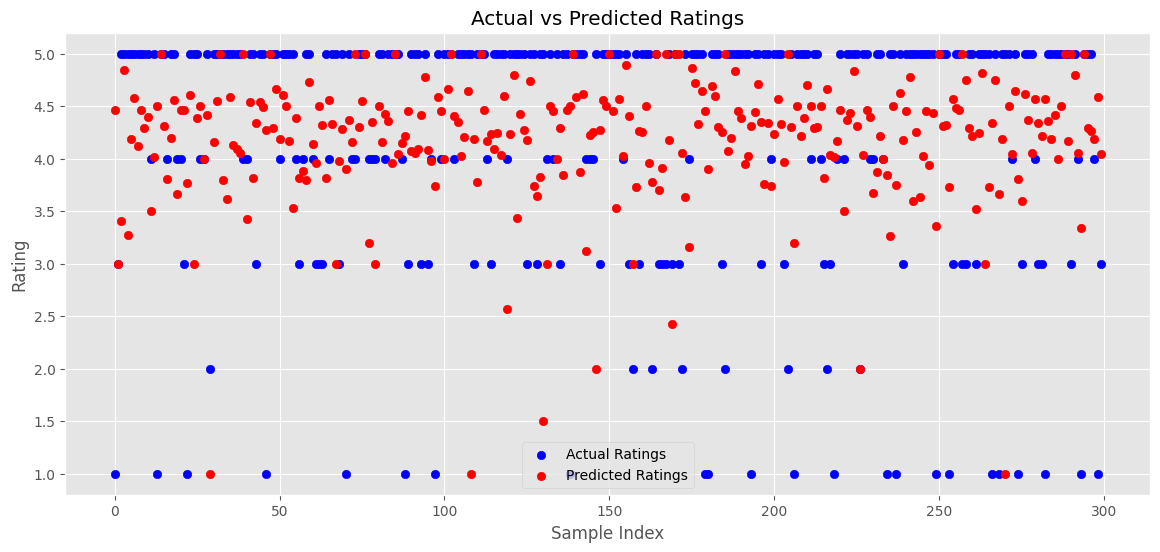

In [137]:
# Chọn một vài mẫu để trực quan hóa
sample_size = 300
sample_indices = np.random.choice(range(len(true_ratings)), size=sample_size, replace=False)

sample_test_ratings = [true_ratings[i] for i in sample_indices]
sample_predicted_ratings = [predicted_ratings[i] for i in sample_indices]

plt.figure(figsize=(14, 6))

# Biểu đồ so sánh giá trị thực tế và giá trị dự đoán
plt.scatter(range(sample_size), sample_test_ratings, color='blue', label='Actual Ratings')
plt.scatter(range(sample_size), sample_predicted_ratings, color='red', label='Predicted Ratings')
plt.title('Actual vs Predicted Ratings')
plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.legend()
plt.grid(True)
plt.show()

Phân bố các giá trị thực tế và dự đoán:

* Các giá trị thực tế phân bố đều trên các mức rating từ 1 đến 5, nghĩa là người dùng đã đánh giá sản phẩm với mọi mức độ khác nhau.

* Các giá trị dự đoán cũng phân bố tương tự nhưng có xu hướng tập trung ở mức trung bình cao hơn, cụ thể là khoảng từ 3.0 đến 5.0.

Sai số:
* Ở các mức rating cao hơn (4.0, 5.0), các dự đoán có xu hướng gần hơn với giá trị thực tế, nhưng vẫn có sự phân tán nhất định.

* Ở các mức rating thấp (1.0, 2.0), các dự đoán thường cao hơn so với thực tế.


Xu hướng:
* Mô hình có xu hướng dự đoán các giá trị rating gần mức trung bình và cao hơn, thay vì các giá trị thấp hơn.

* Đây có thể là lý do dẫn đến một số sai số lớn ở các giá trị rating thấp, làm tăng MAE và RMSE tổng thể.